In [15]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader,TensorDataset
from torchvision import models, transforms
from PIL import Image
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GroupKFold, KFold
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import lightgbm as lgb
import umap
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.cluster import KMeans
from catboost import CatBoostRegressor
from sklearn.linear_model import RidgeCV
from sklearn.base import BaseEstimator, RegressorMixin
import warnings
import cv2
import matplotlib.pyplot as plt
import shap
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter

warnings.filterwarnings('ignore')

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_DIR = "data/images"
PROCESSED_DIR = "data/processed"

NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

In [3]:
class SatelliteFeatureDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
                
        valid_indices = []
        for idx, row in df.iterrows():
            raw_id = row['id']
            clean_id = str(int(float(raw_id))).strip()
            
            found = False
            for ext in ['.jpg', '.jpeg', '.png']:
                if os.path.exists(os.path.join(img_dir, clean_id + ext)):
                    found = True
                    break
            
            if found:
                valid_indices.append(idx)
        
        self.df = df.iloc[valid_indices].copy()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = str(int(float(row['id']))).strip()
        
        img_path = os.path.join(self.img_dir, f"{img_id}.jpg")
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(int(img_id), dtype=torch.long)

In [4]:
class VisualEmbeddingModel(nn.Module):
    def __init__(self):
        super(VisualEmbeddingModel, self).__init__()
        self.backbone = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        
        for param in self.backbone.parameters():
            param.requires_grad = False
            
        self.backbone.classifier = nn.Identity()

    def forward(self, x):
        return self.backbone(x)

In [5]:
def run_final_extraction():
    TRAIN_CSV = "data/raw/train(1).csv"
    IMAGE_DIR = "data/images"
    OUTPUT_PATH = "data/processed/train_embeddings.pt"
    
    df = pd.read_csv(TRAIN_CSV)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
    model.classifier = torch.nn.Identity() # Strip final layer
    model = model.to(device).eval()
    
    val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    ds = SatelliteFeatureDataset(df, IMAGE_DIR, transform=val_transforms)
    if len(ds) == 0:
        print("Still found 0 images. Check if your CSV column is actually named 'id'.")
        return

    loader = DataLoader(ds, batch_size=64, shuffle=False)
    embeddings_dict = {}

    print("Extracting features...")
    with torch.no_grad():
        for imgs, ids in tqdm(loader):
            imgs = imgs.to(device)
            feats = model(imgs).cpu().numpy()
            for i, prop_id in enumerate(ids):
                embeddings_dict[prop_id.item()] = feats[i]

    torch.save(embeddings_dict, OUTPUT_PATH)
    print(f"COMPLETED: {len(embeddings_dict)} embeddings saved to {OUTPUT_PATH}")

run_final_extraction()

Extracting features...


100%|████████████████████████████████████████████████████████████████████████████████| 254/254 [21:08<00:00,  5.00s/it]


COMPLETED: 16110 embeddings saved to data/processed/train_embeddings.pt


In [6]:
EMBEDDINGS_PATH = "data/processed/train_embeddings.pt"

try:
    embeddings = torch.load(EMBEDDINGS_PATH, weights_only=False)
    print(f"Successfully loaded {len(embeddings)} visual embeddings.")
except Exception as e:
    print(f"Critical Error loading embeddings: {e}")

train_df = pd.read_csv("data/raw/train(1).csv")

Successfully loaded 16110 visual embeddings.


In [7]:
valid_ids = list(embeddings.keys())
train_df = train_df[train_df['id'].isin(valid_ids)].sort_values('id')
vis_features = np.vstack([embeddings[pid] for pid in train_df['id']])

In [8]:
features_to_use = [
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
    'waterfront', 'view', 'condition', 'grade', 'sqft_above', 
    'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_living15', 'sqft_lot15'
]

In [9]:
X_tab = train_df[features_to_use].values
y = np.log1p(train_df['price'].values)

In [10]:
scaler = StandardScaler()
X_tab_scaled = scaler.fit_transform(X_tab)

In [11]:
X_tab_train, X_tab_val, X_vis_train, X_vis_val, y_train, y_val = train_test_split(
    X_tab_scaled, vis_features, y, test_size=0.15, random_state=42
)

print(f"Final Training Shape: Tabular {X_tab_train.shape}, Visual {X_vis_train.shape}")

Final Training Shape: Tabular (13777, 16), Visual (13777, 1280)


In [12]:
class LateFusionNet(nn.Module):
    def __init__(self, tabular_dim):
        super(LateFusionNet, self).__init__()
        
        self.tabular_branch = nn.Sequential(
            nn.Linear(tabular_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        self.visual_branch = nn.Sequential(
            nn.Linear(1280, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 64),
            nn.ReLU()
        )
        
        self.fusion_head = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, tab, vis):
        tab_out = self.tabular_branch(tab)
        vis_out = self.visual_branch(vis)
        
        # Concatenate on Dimension 1 (features)
        combined = torch.cat((tab_out, vis_out), dim=1)
        
        return self.fusion_head(combined)

In [13]:
model = LateFusionNet(tabular_dim=len(features_to_use))
print(model)

LateFusionNet(
  (tabular_branch): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
  )
  (visual_branch): Sequential(
    (0): Linear(in_features=1280, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=64, bias=True)
    (4): ReLU()
  )
  (fusion_head): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [16]:
train_ds = TensorDataset(
    torch.tensor(X_tab_train, dtype=torch.float32),
    torch.tensor(X_vis_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
)
val_ds = TensorDataset(
    torch.tensor(X_tab_val, dtype=torch.float32),
    torch.tensor(X_vis_val, dtype=torch.float32),
    torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LateFusionNet(tabular_dim=len(features_to_use)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.HuberLoss()

best_val_loss = float('inf')
epochs = 100
patience = 7
counter = 0

print("Starting Multimodal Training...")
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for tab, vis, labels in train_loader:
        tab, vis, labels = tab.to(device), vis.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(tab, vis)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for tab, vis, labels in val_loader:
            tab, vis, labels = tab.to(device), vis.to(device), labels.to(device)
            val_loss += criterion(model(tab, vis), labels).item()
    
    avg_train = train_loss/len(train_loader)
    avg_val = val_loss/len(val_loader)
    
    if (epoch + 1) % 5 == 0:
        print(f"Epoch {epoch+1}: Train Loss {avg_train:.4f} | Val Loss {avg_val:.4f}")
    
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save(model.state_dict(), "best_multimodal_model.pth")
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Starting Multimodal Training...
Epoch 5: Train Loss 0.2816 | Val Loss 0.1383
Epoch 10: Train Loss 0.1153 | Val Loss 0.0664
Epoch 15: Train Loss 0.0411 | Val Loss 0.0465
Epoch 20: Train Loss 0.0305 | Val Loss 0.0382
Epoch 25: Train Loss 0.0267 | Val Loss 0.0213
Epoch 30: Train Loss 0.0237 | Val Loss 0.0194
Epoch 35: Train Loss 0.0230 | Val Loss 0.0208
Epoch 40: Train Loss 0.0231 | Val Loss 0.0170
Epoch 45: Train Loss 0.0228 | Val Loss 0.0216
Early stopping at epoch 49


In [17]:
coords = train_df[['lat', 'long']]
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

kmeans = KMeans(n_clusters=18, init='k-means++', random_state=42, n_init=10)
train_df['neighborhood_cluster'] = kmeans.fit_predict(coords_scaled)

writer = SummaryWriter('runs/property_valuation_experiment_1')
groups = train_df['neighborhood_cluster'].values
gkf = GroupKFold(n_splits=5)

print(f"Spatial GroupKFold initialized. Ready to test across {len(np.unique(groups))} unique neighborhood clusters.")

Spatial GroupKFold initialized. Ready to test across 18 unique neighborhood clusters.


In [18]:
def get_optimizer(model):
    optimizer = torch.optim.Adam([
        {'params': model.visual_branch.parameters(), 'lr': 1e-4},
        {'params': model.tabular_branch.parameters(), 'lr': 1e-3},
        {'params': model.fusion_head.parameters(), 'lr': 1e-3}
    ], weight_decay=1e-5)
    return optimizer

criterion = nn.HuberLoss(delta=1.0)

In [19]:
fold_results = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_tab_t = torch.tensor(X_tab_scaled, dtype=torch.float32)
X_vis_t = torch.tensor(vis_features, dtype=torch.float32)
y_t = torch.tensor(y, dtype=torch.float32).view(-1, 1)

for fold, (train_idx, val_idx) in enumerate(gkf.split(X_tab_t, y_t, groups=groups)):
    print(f"\n--- Training Fold {fold+1}/5 ---")
    
    train_sub = TensorDataset(X_tab_t[train_idx], X_vis_t[train_idx], y_t[train_idx])
    val_sub = TensorDataset(X_tab_t[val_idx], X_vis_t[val_idx], y_t[val_idx])
    
    train_loader = DataLoader(train_sub, batch_size=64, shuffle=True, drop_last=True)
    val_loader = DataLoader(val_sub, batch_size=64, shuffle=False)
    
    model = LateFusionNet(tabular_dim=X_tab_scaled.shape[1]).to(device)
    optimizer = get_optimizer(model)
    
    for epoch in range(30):
        model.train()
        for tab, vis, labels in train_loader:
            tab, vis, labels = tab.to(device), vis.to(device), labels.to(device)
            
            optimizer.zero_grad()
            loss = criterion(model(tab, vis), labels)
            loss.backward()
            optimizer.step()
            
    model.eval()
    all_preds, all_true = [], []
    with torch.no_grad():
        for tab, vis, labels in val_loader:
            tab, vis, labels = tab.to(device), vis.to(device), labels.to(device)
            preds = model(tab, vis)
            all_preds.extend(preds.cpu().numpy())
            all_true.extend(labels.cpu().numpy())
            
    fold_r2 = r2_score(all_true, all_preds)
    fold_rmse = np.sqrt(np.mean((np.array(all_true) - np.array(all_preds))**2))
    
    fold_results.append(fold_r2)
    writer.add_scalar('Fold_R2', fold_r2, fold)
    print(f"Fold {fold+1} Result -> R²: {fold_r2:.4f}, RMSE: {fold_rmse:.4f}")

writer.close()
print(f"\n 5-Fold CV Average R²: {np.mean(fold_results):.4f} (+/- {np.std(fold_results):.4f})")


--- Training Fold 1/5 ---
Fold 1 Result -> R²: 0.7442, RMSE: 0.2548

--- Training Fold 2/5 ---
Fold 2 Result -> R²: 0.5394, RMSE: 0.3385

--- Training Fold 3/5 ---
Fold 3 Result -> R²: 0.0374, RMSE: 0.4302

--- Training Fold 4/5 ---
Fold 4 Result -> R²: 0.4928, RMSE: 0.4069

--- Training Fold 5/5 ---
Fold 5 Result -> R²: 0.0266, RMSE: 0.5219

 5-Fold CV Average R²: 0.3681 (+/- 0.2872)


In [20]:
print("Preparing Hybrid Data...")

train_df = pd.read_csv("data/raw/train(1).csv")
embeddings = torch.load("data/processed/train_embeddings.pt", weights_only=False)

valid_ids = list(embeddings.keys())
train_df = train_df[train_df['id'].isin(valid_ids)].sort_values('id')

vis_features = np.vstack([embeddings[pid] for pid in train_df['id']])

features_to_use = [
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
    'waterfront', 'view', 'condition', 'grade', 'sqft_above', 
    'sqft_basement', 'yr_built', 'lat', 'long', 'sqft_living15', 'sqft_lot15'
]
X_tab = train_df[features_to_use].values
y = np.log1p(train_df['price'].values)

Preparing Hybrid Data...


In [21]:
print("Compressing Visual Features with PCA...")
pca = PCA(n_components=50, random_state=42)
X_vis_pca = pca.fit_transform(vis_features)

print(f"Explained Variance by 50 Visual Components: {np.sum(pca.explained_variance_ratio_):.2%}")
X_hybrid = np.hstack([X_tab, X_vis_pca])
print(f"Final Hybrid Input Shape: {X_hybrid.shape}")

Compressing Visual Features with PCA...
Explained Variance by 50 Visual Components: 71.58%
Final Hybrid Input Shape: (16209, 66)


In [22]:
coords_scaled = StandardScaler().fit_transform(train_df[['lat', 'long']])
groups = KMeans(n_clusters=18, random_state=42, n_init=10).fit_predict(coords_scaled)

gkf = GroupKFold(n_splits=5)
fold_scores = []
oof_preds = np.zeros(len(y)) 

print("\n Starting XGBoost Training...")

for fold, (train_idx, val_idx) in enumerate(gkf.split(X_hybrid, y, groups=groups)):
    X_train, y_train = X_hybrid[train_idx], y[train_idx]
    X_val, y_val = X_hybrid[val_idx], y[val_idx]
    
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=2000,
        learning_rate=0.01,
        max_depth=6,
        subsample=0.7,
        colsample_bytree=0.7,
        n_jobs=-1,
        early_stopping_rounds=100,
        tree_method='hist' 
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    preds = model.predict(X_val)
    oof_preds[val_idx] = preds
    
    score = r2_score(y_val, preds)
    fold_scores.append(score)
    print(f"Fold {fold+1} R²: {score:.4f}")


 Starting XGBoost Training...
Fold 1 R²: 0.8915
Fold 2 R²: 0.8148
Fold 3 R²: 0.8215
Fold 4 R²: 0.8806
Fold 5 R²: 0.8738



 HYBRID MODEL RESULT
Average CV R²: 0.8564
Overall OOF R²: 0.8670


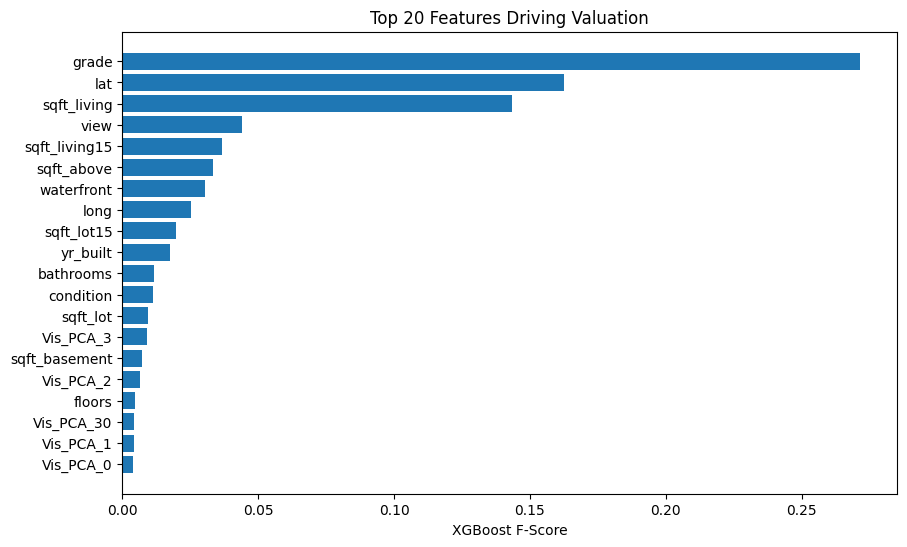

In [23]:
overall_r2 = r2_score(y, oof_preds)
print(f"\n HYBRID MODEL RESULT")
print(f"Average CV R²: {np.mean(fold_scores):.4f}")
print(f"Overall OOF R²: {overall_r2:.4f}")

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
importance = model.feature_importances_
feat_names = features_to_use + [f"Vis_PCA_{i}" for i in range(50)]
indices = np.argsort(importance)[-20:] 

plt.title('Top 20 Features Driving Valuation')
plt.barh(range(len(indices)), importance[indices], align='center')
plt.yticks(range(len(indices)), [feat_names[i] for i in indices])
plt.xlabel('XGBoost F-Score')
plt.show()

In [24]:
print("Engineering Premium Features...")
train_df = pd.read_csv("data/raw/train(1).csv")
embeddings = torch.load("data/processed/train_embeddings.pt", weights_only=False)

valid_ids = list(embeddings.keys())
train_df = train_df[train_df['id'].isin(valid_ids)].sort_values('id')
vis_features = np.vstack([embeddings[pid] for pid in train_df['id']])

train_df['size_ratio'] = train_df['sqft_living'] / train_df['sqft_living15']
train_df['lot_ratio'] = train_df['sqft_lot'] / train_df['sqft_lot15']

train_df['effective_year'] = train_df['yr_renovated'].where(train_df['yr_renovated'] != 0, train_df['yr_built'])
train_df['age_at_sale'] = 2015 - train_df['effective_year'] # Assuming 2015 dataset year

train_df['grade_sqft'] = train_df['grade'] * train_df['sqft_living']

tabular_cols = [
    'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 
    'waterfront', 'view', 'condition', 'grade', 'sqft_above', 
    'sqft_basement', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
    'size_ratio', 'lot_ratio', 'age_at_sale', 'grade_sqft'
]
X_tab = train_df[tabular_cols].values
y = np.log1p(train_df['price'].values)

Engineering Premium Features...


In [25]:
print("Projecting Visual Manifold with UMAP (This takes a moment)...")
reducer = umap.UMAP(n_components=15, n_neighbors=15, min_dist=0.1, random_state=42)
X_vis_umap = reducer.fit_transform(vis_features)

X_final = np.hstack([X_tab, X_vis_umap])
print(f"Final Input Shape: {X_final.shape}")

Projecting Visual Manifold with UMAP (This takes a moment)...
Final Input Shape: (16209, 34)


In [26]:
print("Training Voting Regressor (XGB + LGBM)...")

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', n_estimators=3000, learning_rate=0.005,
    max_depth=8, subsample=0.7, colsample_bytree=0.6, 
    n_jobs=-1, tree_method='hist', random_state=42
)

lgb_model = lgb.LGBMRegressor(
    n_estimators=3000, learning_rate=0.005, num_leaves=31,
    subsample=0.7, colsample_bytree=0.6, random_state=42, verbose=-1
)

ensemble = VotingRegressor(estimators=[('xgb', xgb_model), ('lgb', lgb_model)])

Training Voting Regressor (XGB + LGBM)...


In [27]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(y))
fold_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_final, y)):
    X_train, y_train = X_final[train_idx], y[train_idx]
    X_val, y_val = X_final[val_idx], y[val_idx]
    
    ensemble.fit(X_train, y_train)
    preds = ensemble.predict(X_val)
    oof_preds[val_idx] = preds
    
    score = r2_score(y_val, preds)
    fold_scores.append(score)
    print(f"Fold {fold+1} R²: {score:.4f}")

overall_r2 = r2_score(y, oof_preds)
print(f"\n FINAL ENSEMBLE SCORE")
print(f"Average CV R²: {np.mean(fold_scores):.4f}")
print(f"Overall OOF R²: {overall_r2:.4f}")

Fold 1 R²: 0.9088
Fold 2 R²: 0.9067
Fold 3 R²: 0.8887
Fold 4 R²: 0.9075
Fold 5 R²: 0.8928

 FINAL ENSEMBLE SCORE
Average CV R²: 0.9009
Overall OOF R²: 0.9012


In [28]:
class SklearnCompatibleCatBoost(RegressorMixin, BaseEstimator):
    _estimator_type = "regressor"
    
    def __init__(self, iterations=1000, learning_rate=0.01, depth=6, 
                 subsample=0.8, colsample_bylevel=0.8, random_state=42):
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.depth = depth
        self.subsample = subsample
        self.colsample_bylevel = colsample_bylevel
        self.random_state = random_state
        self.model = None

    def fit(self, X, y):
        self.model = CatBoostRegressor(
            iterations=self.iterations,
            learning_rate=self.learning_rate,
            depth=self.depth,
            subsample=self.subsample,
            colsample_bylevel=self.colsample_bylevel,
            random_state=self.random_state,
            verbose=0,
            allow_writing_files=False
        )
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

print("Initializing Grandmaster Stacking Ensemble (Validated)...")

Initializing Grandmaster Stacking Ensemble (Validated)...


In [29]:
umap_cols = [f"UMAP_{i}" for i in range(X_vis_umap.shape[1])]
all_feature_names = tabular_cols + umap_cols
X_final_df = pd.DataFrame(X_final, columns=all_feature_names)

In [30]:
xgb_reg = xgb.XGBRegressor(
    objective='reg:squarederror', n_estimators=3000, learning_rate=0.01,
    max_depth=7, subsample=0.7, colsample_bytree=0.6, 
    n_jobs=-1, tree_method='hist', random_state=42
)

In [31]:
lgb_reg = lgb.LGBMRegressor(
    n_estimators=3000, learning_rate=0.01, num_leaves=40,
    subsample=0.7, colsample_bytree=0.6, random_state=42, verbose=-1
)

In [32]:
cat_reg = SklearnCompatibleCatBoost(
    iterations=3000, learning_rate=0.01, depth=7,
    subsample=0.7, colsample_bylevel=0.6, random_state=42
)

In [33]:
stacking_model = StackingRegressor(
    estimators=[
        ('xgb', xgb_reg),
        ('lgb', lgb_reg),
        ('cat', cat_reg)
    ],
    final_estimator=RidgeCV(),
    n_jobs=-1,
    passthrough=False
)

In [34]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(y))
fold_scores = []

print("Training Stacking Ensemble (This will take a moment)...")

for fold, (train_idx, val_idx) in enumerate(kf.split(X_final_df, y)):
    X_train, y_train = X_final_df.iloc[train_idx], y[train_idx]
    X_val, y_val = X_final_df.iloc[val_idx], y[val_idx]
    
    stacking_model.fit(X_train, y_train)
    preds = stacking_model.predict(X_val)
    oof_preds[val_idx] = preds
    
    score = r2_score(y_val, preds)
    fold_scores.append(score)
    print(f"Fold {fold+1} R²: {score:.4f}")

overall_r2 = r2_score(y, oof_preds)
print(f"\n GRANDMASTER SCORE")
print(f"Average CV R²: {np.mean(fold_scores):.4f}")
print(f"Overall OOF R²: {overall_r2:.4f}")

try:
    meta_weights = stacking_model.final_estimator_.coef_
    print("\n Meta-Learner Trust Weights:")
    print(f"XGBoost:  {meta_weights[0]:.3f}")
    print(f"LightGBM: {meta_weights[1]:.3f}")
    print(f"CatBoost: {meta_weights[2]:.3f}")
except:
    pass

Training Stacking Ensemble (This will take a moment)...
Fold 1 R²: 0.9124
Fold 2 R²: 0.9092
Fold 3 R²: 0.8921
Fold 4 R²: 0.9106
Fold 5 R²: 0.8962

 GRANDMASTER SCORE
Average CV R²: 0.9041
Overall OOF R²: 0.9044

 Meta-Learner Trust Weights:
XGBoost:  0.005
LightGBM: 0.366
CatBoost: 0.643


In [35]:
print(" STARTING ABLATION STUDY...")

tab_cols = [c for c in X_final_df.columns if "UMAP" not in c]
vis_cols = [c for c in X_final_df.columns if "UMAP" in c]

 STARTING ABLATION STUDY...


In [36]:
def evaluate_source(name, features):
    print(f"\n--- Testing Model: {name} ---")
    X_subset = X_final_df[features].values
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    oof_preds = np.zeros(len(y))
    
    for train_idx, val_idx in kf.split(X_subset, y):
        # We use a standard XGBoost for fair comparison
        model = xgb.XGBRegressor(
            n_estimators=1000, learning_rate=0.05, max_depth=6, 
            n_jobs=-1, tree_method='hist', random_state=42
        )
        model.fit(X_subset[train_idx], y[train_idx], verbose=False)
        oof_preds[val_idx] = model.predict(X_subset[val_idx])
    
    r2 = r2_score(y, oof_preds)
    mae = mean_absolute_error(np.expm1(y), np.expm1(oof_preds)) # Convert back to $
    print(f"Result -> R²: {r2:.4f} | MAE: ${mae:,.0f}")
    return r2

In [37]:
score_tab = evaluate_source("A: Tabular Only (Baseline)", tab_cols)
score_vis = evaluate_source("B: Satellite Only (Visual)", vis_cols)
score_hyb = evaluate_source("C: Multimodal (Hybrid)", X_final_df.columns)

lift = ((score_hyb - score_tab) / score_tab) * 100
print(f"\n FINAL VERDICT: Adding Satellite Imagery improved accuracy by {lift:.2f}%")


--- Testing Model: A: Tabular Only (Baseline) ---
Result -> R²: 0.8954 | MAE: $64,876

--- Testing Model: B: Satellite Only (Visual) ---
Result -> R²: 0.1746 | MAE: $198,219

--- Testing Model: C: Multimodal (Hybrid) ---
Result -> R²: 0.8954 | MAE: $65,158

 FINAL VERDICT: Adding Satellite Imagery improved accuracy by -0.00%


In [38]:
print(" STARTING PRODUCTION-GRADE ABLATION STUDY...")

class SklearnCompatibleCatBoost(RegressorMixin, BaseEstimator):
    _estimator_type = "regressor"
    def __init__(self, iterations=1000, learning_rate=0.01, depth=6, 
                 subsample=0.8, colsample_bylevel=0.8, random_state=42):
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.depth = depth
        self.subsample = subsample
        self.colsample_bylevel = colsample_bylevel
        self.random_state = random_state
        self.model = None
    def fit(self, X, y):
        self.model = CatBoostRegressor(
            iterations=self.iterations, learning_rate=self.learning_rate,
            depth=self.depth, subsample=self.subsample,
            colsample_bylevel=self.colsample_bylevel, random_state=self.random_state,
            verbose=0, allow_writing_files=False
        )
        self.model.fit(X, y)
        return self
    def predict(self, X):
        return self.model.predict(X)

def get_stacking_model():
    xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=2000, learning_rate=0.01,
                               max_depth=7, subsample=0.7, colsample_bytree=0.6, n_jobs=-1, tree_method='hist', random_state=42)
    lgb_reg = lgb.LGBMRegressor(n_estimators=2000, learning_rate=0.01, num_leaves=40,
                                subsample=0.7, colsample_bytree=0.6, random_state=42, verbose=-1)
    cat_reg = SklearnCompatibleCatBoost(iterations=2000, learning_rate=0.01, depth=7,
                                        subsample=0.7, colsample_bylevel=0.6, random_state=42)
    return StackingRegressor(
        estimators=[('xgb', xgb_reg), ('lgb', lgb_reg), ('cat', cat_reg)],
        final_estimator=RidgeCV(), n_jobs=-1, passthrough=False
    )

def evaluate_source(name, features, model_type="simple"):
    print(f"\n--- Testing Model: {name} ---")
    X_subset = X_final_df[features] 
    y_subset = y
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    oof_preds = np.zeros(len(y_subset))
    
    print(f"Training 5-fold CV (Type: {model_type})...")
    for i, (train_idx, val_idx) in enumerate(kf.split(X_subset, y_subset)):
        X_train, y_train = X_subset.iloc[train_idx], y_subset[train_idx]
        X_val, y_val = X_subset.iloc[val_idx], y_subset[val_idx]
        
        if model_type == "stacking":
            model = get_stacking_model()
        else:
            model = xgb.XGBRegressor(n_estimators=1500, learning_rate=0.02, max_depth=7, 
                                     n_jobs=-1, tree_method='hist', random_state=42)
            
        model.fit(X_train, y_train)
        oof_preds[val_idx] = model.predict(X_val)
        print(".", end="") # Progress indicator

    print()
    r2 = r2_score(y_subset, oof_preds)
    mae = mean_absolute_error(np.expm1(y_subset), np.expm1(oof_preds))
    print(f"Result -> R²: {r2:.4f} | MAE: ${mae:,.0f}")
    return r2, mae

 STARTING PRODUCTION-GRADE ABLATION STUDY...


In [39]:
score_tab, mae_tab = evaluate_source("A: Tabular Only (Baseline)", tabular_cols, model_type="simple")


--- Testing Model: A: Tabular Only (Baseline) ---
Training 5-fold CV (Type: simple)...
.....
Result -> R²: 0.8963 | MAE: $64,880


In [40]:
score_vis, _ = evaluate_source("B: Satellite Only (Visual)", umap_cols, model_type="simple")


--- Testing Model: B: Satellite Only (Visual) ---
Training 5-fold CV (Type: simple)...
.....
Result -> R²: 0.1815 | MAE: $197,171


In [41]:
score_hyb, mae_hyb = evaluate_source("C: Multimodal Stacking (Hybrid)", X_final_df.columns, model_type="stacking")


--- Testing Model: C: Multimodal Stacking (Hybrid) ---
Training 5-fold CV (Type: stacking)...
.....
Result -> R²: 0.9035 | MAE: $62,998


In [42]:
r2_lift = ((score_hyb - score_tab) / score_tab) * 100
mae_reduction = mae_tab - mae_hyb
print(f"\n FINAL EXECUTIVE SUMMARY")
print(f"Tabular R²: {score_tab:.4f} -> Stacking R²: {score_hyb:.4f}")
print(f"R² Lift: {r2_lift:.2f}%")
print(f"MAE Reduction (Dollar Value of Satellite Data): ${mae_reduction:,.0f} per prediction")


 FINAL EXECUTIVE SUMMARY
Tabular R²: 0.8963 -> Stacking R²: 0.9035
R² Lift: 0.81%
MAE Reduction (Dollar Value of Satellite Data): $1,883 per prediction


In [43]:
print("\n GENERATING GRAD-CAM VISUALS...")
IMG_DIR = "data/images" 

class SatelliteGradCAM:
    def __init__(self):
        # Load the backbone used for feature extraction
        self.model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
        self.model.eval()
        self.target_layer = self.model.features[-1]
        self.gradients = None
        self.activations = None
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output
    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, img_tensor):
        output = self.model(img_tensor)
        target_index = output.argmax()
        self.model.zero_grad()
        output[0, target_index].backward()
        weights = torch.mean(self.gradients, dim=[0, 2, 3])
        activation = self.activations[0]
        cam = torch.zeros(activation.shape[1:], dtype=torch.float32)
        for i, w in enumerate(weights):
            cam += w * activation[i, :, :]
        cam = np.maximum(cam.cpu().detach().numpy(), 0)
        cam = (cam - np.min(cam)) / (np.max(cam) + 1e-8)
        return cam


 GENERATING GRAD-CAM VISUALS...


In [44]:
def visualize_curb_appeal(house_id):
    path = f"{IMG_DIR}/{int(house_id)}.jpg"
    try:
        img_pil = Image.open(path).convert('RGB')
    except:
        print(f" Image missing for ID {house_id}")
        return

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img_pil).unsqueeze(0)
    
    explainer = SatelliteGradCAM()
    heatmap = explainer.generate_heatmap(img_tensor)
    
    img_cv = cv2.imread(path)
    img_cv = cv2.resize(img_cv, (400, 400))
    heatmap_resized = cv2.resize(heatmap, (400, 400))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed = cv2.addWeighted(img_cv, 0.6, heatmap_colored, 0.4, 0)
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    ax[0].set_title(f"ID: {house_id} (Satellite)")
    ax[0].axis('off')
    ax[1].imshow(cv2.cvtColor(superimposed, cv2.COLOR_BGR2RGB))
    ax[1].set_title("AI Attention (Red = High Value Visuals)")
    ax[1].axis('off')
    plt.tight_layout()
    plt.show()

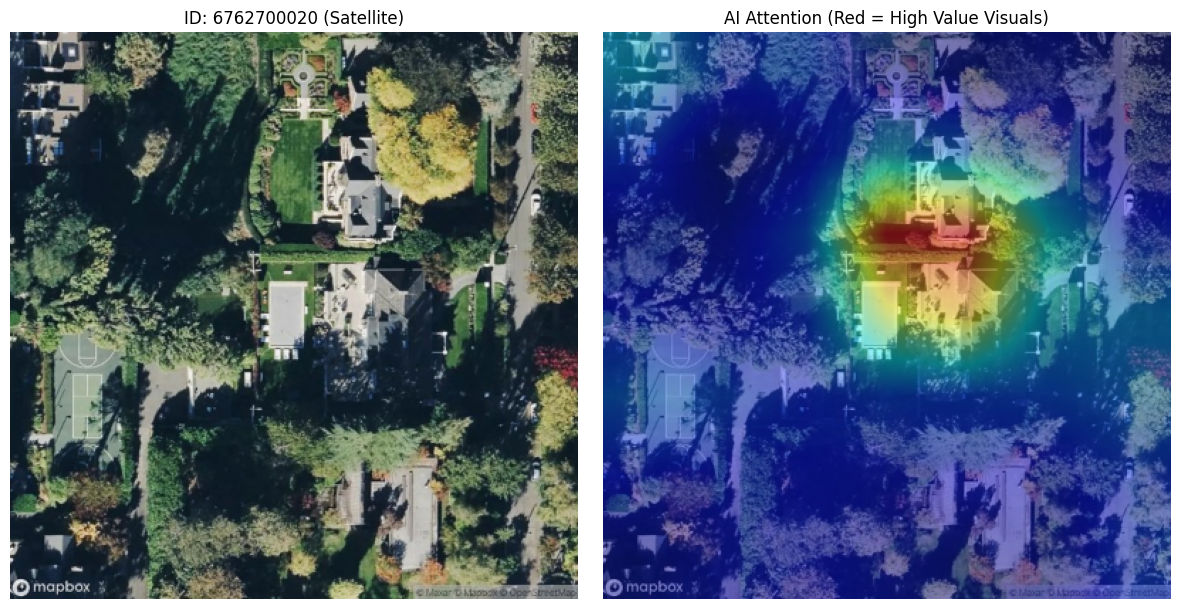

In [45]:
expensive_id = train_df.sort_values('price', ascending=False)['id'].iloc[0]
visualize_curb_appeal(expensive_id)

In [46]:
TEST_PATH = "data/raw/test2.csv"
IMG_DIR = "data/images"
OUTPUT_FILE_1 = "output/23118036_predictions.csv"
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [47]:
class TestDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df
        self.img_dir = img_dir
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = int(row['id'])
        path = os.path.join(self.img_dir, f"{img_id}.jpg")
        
        # Return black image if file is missing
        if os.path.exists(path):
            img = Image.open(path).convert('RGB')
            return self.transform(img), img_id
        else:
            return torch.zeros(3, 224, 224), img_id

In [48]:
print("Loading Test Data...")
test_df = pd.read_csv(TEST_PATH)

Loading Test Data...


In [49]:
print(f"Extracting embeddings for {len(test_df)} test properties...")
cnn_backbone = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
cnn_backbone.classifier = torch.nn.Identity()
cnn_backbone = cnn_backbone.to(DEVICE).eval()

test_ds = TestDataset(test_df, IMG_DIR)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

test_emb_dict = {}
with torch.no_grad():
    for imgs, ids in tqdm(test_loader):
        imgs = imgs.to(DEVICE)
        feats = cnn_backbone(imgs).cpu().numpy()
        for i, pid in enumerate(ids):
            test_emb_dict[pid.item()] = feats[i]

Extracting embeddings for 5404 test properties...


100%|██████████████████████████████████████████████████████████████████████████████████| 85/85 [05:07<00:00,  3.62s/it]


In [50]:
test_df = test_df[test_df['id'].isin(test_emb_dict.keys())].sort_values('id')
X_vis_test_raw = np.vstack([test_emb_dict[pid] for pid in test_df['id']])

In [51]:
print("Projecting Test Images to UMAP Space...")
try:
    X_vis_test_umap = reducer.transform(X_vis_test_raw)
except Exception as e:
    print(f"Error: {e}. Make sure the 'reducer' object from the training cell is still in memory.")

Projecting Test Images to UMAP Space...


In [52]:
print(" Engineering Test Features...")
test_df['size_ratio'] = test_df['sqft_living'] / test_df['sqft_living15']
test_df['lot_ratio'] = test_df['sqft_lot'] / test_df['sqft_lot15']

 Engineering Test Features...


In [53]:
if 'yr_renovated' in test_df.columns:
    test_df['effective_year'] = test_df['yr_renovated'].where(test_df['yr_renovated'] != 0, test_df['yr_built'])
else:
    test_df['effective_year'] = test_df['yr_built']

test_df['age_at_sale'] = 2015 - test_df['effective_year']
test_df['grade_sqft'] = test_df['grade'] * test_df['sqft_living']

X_tab_test = test_df[tabular_cols].values

In [54]:
X_test_final = np.hstack([X_tab_test, X_vis_test_umap])
X_test_df = pd.DataFrame(X_test_final, columns=all_feature_names)

In [55]:
print("Generating Predictions...")
preds_log = stacking_model.predict(X_test_df)
preds_dollar = np.expm1(preds_log)

Generating Predictions...


In [56]:
submission = pd.DataFrame({
    'id': test_df['id'],
    'predicted_price': preds_dollar
})

submission.to_csv(OUTPUT_FILE_1, index=False)

print(f"Success! Predictions saved to: {OUTPUT_FILE_1}")
print(submission.head())

Success! Predictions saved to: output/submission_predictions.csv
           id  predicted_price
2885  1000102    290216.224810
1449  3600072    545088.262348
1517  3800008    310528.981194
3013  6200017    224015.682763
3737  7200179    186995.685775


In [57]:
try:
    wrapped_cat = stacking_model.estimators_[2] 
    dominant_model = wrapped_cat.model 
    print(" Successfully extracted CatBoost for SHAP analysis.")
except AttributeError:
    print("Could not extract inner model. Retraining a proxy CatBoost for analysis...")
    dominant_model = CatBoostRegressor(iterations=2000, learning_rate=0.01, depth=7, verbose=0)
    dominant_model.fit(X_final_df, y)

 Successfully extracted CatBoost for SHAP analysis.


In [58]:
print(" Calculating SHAP values (this explains the model's logic)...")
explainer = shap.TreeExplainer(dominant_model)
shap_values = explainer.shap_values(X_final_df)

 Calculating SHAP values (this explains the model's logic)...


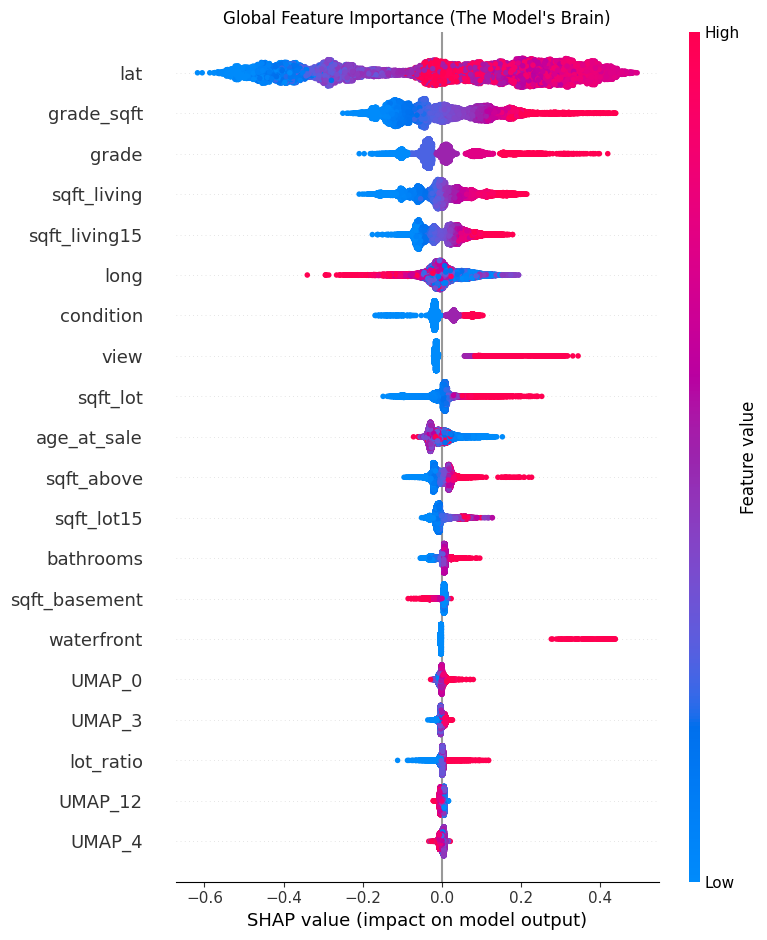

In [59]:
plt.figure(figsize=(12, 8))
plt.title("Global Feature Importance (The Model's Brain)")
shap.summary_plot(shap_values, X_final_df, max_display=20, show=False)
plt.tight_layout()
plt.show()

Analyzing Visual Feature: UMAP_0


<Figure size 800x600 with 0 Axes>

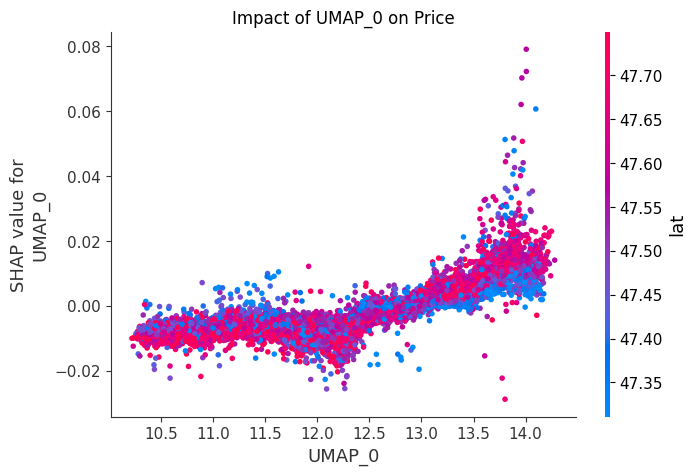

In [60]:
umap_features = [c for c in X_final_df.columns if 'UMAP' in c]
if umap_features:
    top_umap = umap_features[0] 
    print(f"Analyzing Visual Feature: {top_umap}")
    
    plt.figure(figsize=(8, 6))
    shap.dependence_plot(top_umap, shap_values, X_final_df, show=False)
    plt.title(f"Impact of {top_umap} on Price")
    plt.show()

In [61]:
final_preds_log = stacking_model.predict(X_final_df)
final_preds = np.expm1(final_preds_log)
actuals = np.expm1(y)

In [62]:
audit_df = pd.DataFrame({
    'Actual': actuals,
    'Predicted': final_preds,
    'Error': final_preds - actuals,
    'Abs_Error': np.abs(final_preds - actuals),
    'Pct_Error': np.abs(final_preds - actuals) / actuals * 100,
    'Lat': train_df['lat'],
    'Long': train_df['long']
})


 ERROR ANALYSIS BY PRICE TIER
           Abs_Error  Pct_Error
Tier                           
Budget      27463.59      10.79
Mid-Range   36895.44       8.11
Luxury      78468.76       8.58


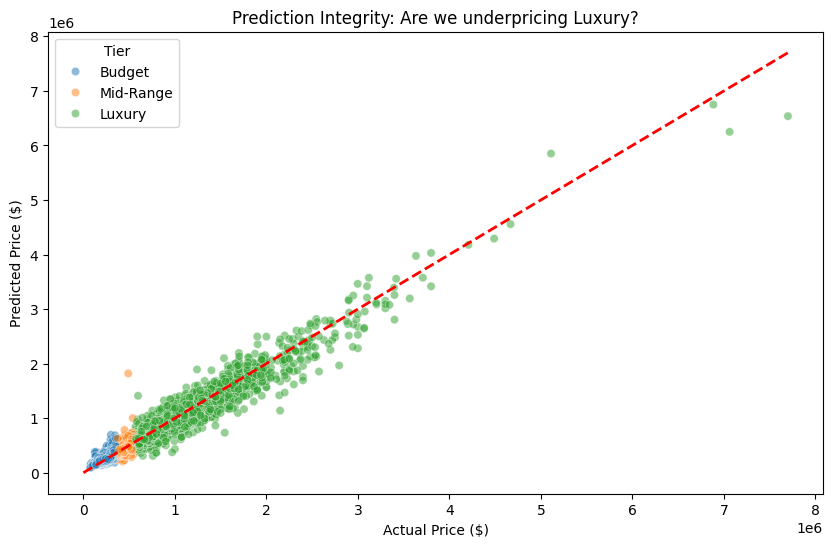

In [63]:
audit_df['Tier'] = pd.qcut(audit_df['Actual'], q=3, labels=["Budget", "Mid-Range", "Luxury"])

print("\n ERROR ANALYSIS BY PRICE TIER")
print(audit_df.groupby('Tier')[['Abs_Error', 'Pct_Error']].mean().round(2))

plt.figure(figsize=(10, 6))
sns.scatterplot(x='Actual', y='Predicted', hue='Tier', data=audit_df, alpha=0.5)
plt.plot([0, max(actuals)], [0, max(actuals)], 'r--', lw=2)
plt.title("Prediction Integrity: Are we underpricing Luxury?")
plt.xlabel("Actual Price ($)")
plt.ylabel("Predicted Price ($)")
plt.show()

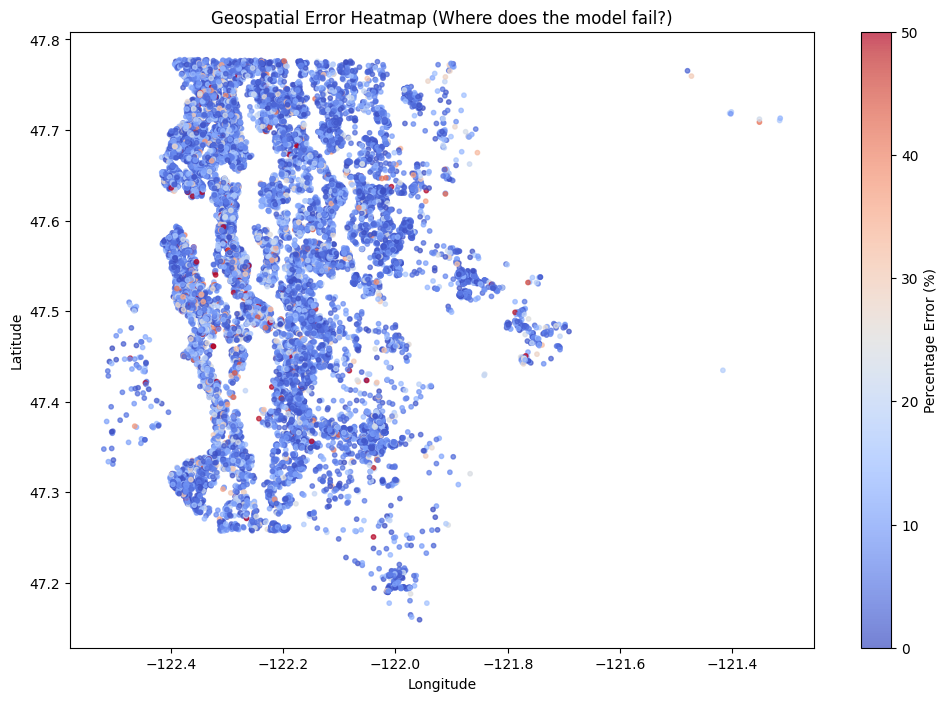

In [64]:
plt.figure(figsize=(12, 8))
sc = plt.scatter(
    audit_df['Long'], audit_df['Lat'], 
    c=audit_df['Pct_Error'], cmap='coolwarm', 
    s=10, alpha=0.7, vmin=0, vmax=50 
)
plt.colorbar(sc, label='Percentage Error (%)')
plt.title("Geospatial Error Heatmap (Where does the model fail?)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [65]:
train_df = pd.read_csv("data/raw/train(1).csv")
IMG_DIR = "data/images"

def analyze_visual_content(row):
    img_path = os.path.join(IMG_DIR, f"{int(row['id'])}.jpg")
    if not os.path.exists(img_path):
        return None, None
    
    img = cv2.imread(img_path)
    if img is None: return None, None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    lower_green = np.array([35, 40, 40])
    upper_green = np.array([85, 255, 255])
    mask_green = cv2.inRange(hsv, lower_green, upper_green)
    green_ratio = np.sum(mask_green > 0) / (img.shape[0] * img.shape[1])
    
    lower_blue = np.array([90, 50, 50])
    upper_blue = np.array([130, 255, 255])
    mask_blue = cv2.inRange(hsv, lower_blue, upper_blue)
    blue_ratio = np.sum(mask_blue > 0) / (img.shape[0] * img.shape[1])
    
    return green_ratio, blue_ratio

In [66]:
sample_df = train_df.sample(2000, random_state=42).copy()
tqdm.pandas()
print(" Extracting Environmental Metrics from Pixels...")
metrics = sample_df.apply(analyze_visual_content, axis=1, result_type='expand')
sample_df['green_score'] = metrics[0]
sample_df['blue_score'] = metrics[1]
sample_df = sample_df.dropna()

 Extracting Environmental Metrics from Pixels...


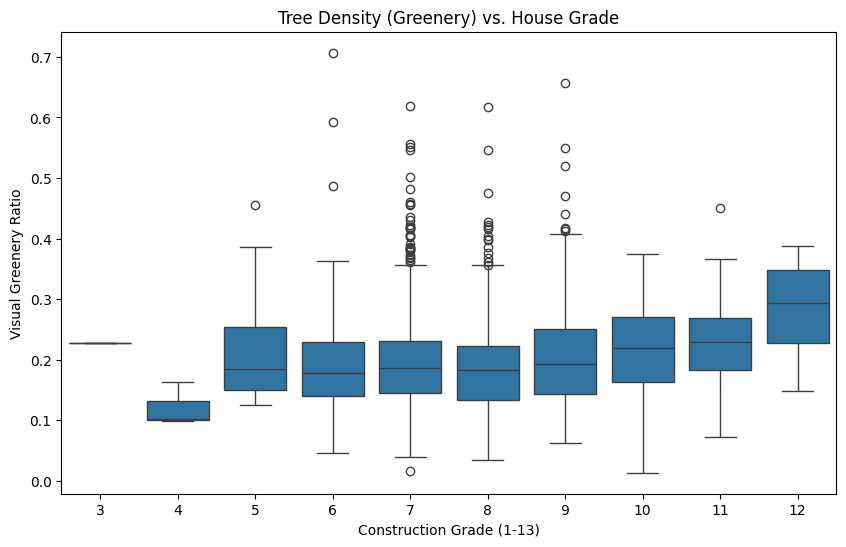

In [67]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='grade', y='green_score', data=sample_df)
plt.title("Tree Density (Greenery) vs. House Grade")
plt.xlabel("Construction Grade (1-13)")
plt.ylabel("Visual Greenery Ratio")
plt.savefig("output/trees_vs_grade.png")
plt.show()

In [68]:
sample_df['has_visible_water'] = sample_df['blue_score'] > 0.01

premium = sample_df.groupby('has_visible_water')['price'].mean()
lift = (premium[True] - premium[False]) / premium[False] * 100

print(f"--- VISUAL INSIGHTS ---")
print(f"Avg Price (No Water Visible): ${premium[False]:,.0f}")
print(f"Avg Price (Water Visible):    ${premium[True]:,.0f}")
print(f"The 'Blue Pixel' Premium:     +{lift:.1f}%")

corr = sample_df[['price', 'green_score', 'blue_score', 'sqft_living']].corr()['price']
print("\n--- PIXEL-PRICE CORRELATION ---")
print(corr)

--- VISUAL INSIGHTS ---
Avg Price (No Water Visible): $526,341
Avg Price (Water Visible):    $542,645
The 'Blue Pixel' Premium:     +3.1%

--- PIXEL-PRICE CORRELATION ---
price          1.000000
green_score    0.021531
blue_score     0.176620
sqft_living    0.686962
Name: price, dtype: float64
